## Load libraries

In [1]:
import pandas as pd
import joblib
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score

from matplotlib.colors import LinearSegmentedColormap
import shap
import keras

from math import pi

from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
from scipy import stats
from scipy.stats import t

from scipy.stats import bootstrap
from scipy.stats import sem

c:\Users\gvillanueva\Desktop\Projects\Mental_health_COVID19\ds2023\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\gvillanueva\Desktop\Projects\Mental_health_COVID19\ds2023\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-whe

In [2]:
import sys
import os

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

In [3]:
from src import utils
from src.config import CONFIG

In [15]:
# ########### Load data ############
print('Loadind data ...')
df_data, df_codebook  = utils.read_data(CONFIG.path_dataset, CONFIG.path_codebook)
df_data = utils.data_preprocessing(df_data,df_codebook,CONFIG.non_relevant_vars, CONFIG.outcomes)

############ Set target ############
print('Target discretization ...')
X,y_4 = utils.set_target(df_data,CONFIG.outcomes,CONFIG.thr_disc_1,CONFIG.thr_disc_2)
y_3 = y_4.drop('G_HADSscore',axis=1)

print('Number of features =',len(X.columns))
print('--------------------------------------------------------')

print('Number of samples =',X.shape[0])
print('--------------------------------------------------------')

############ Data encoding ############
X, num_vars, categ_vars = utils.data_encoding(X,CONFIG.additional_categ_var)

print('Number of categorical features =',len(categ_vars))
print('--------------------------------------------------------')
print('Number of numerical features =',len(num_vars))
print('--------------------------------------------------------')

missing_data=X.isna().sum()
missing_data = missing_data[missing_data != 0]

print('Number of features with missing values =', len(missing_data))
print('Percentage of missing data = ', round(100*missing_data.sum()/(X.shape[0]*X.shape[1]),2))
print('--------------------------------------------------------')

Loadind data ...
Target discretization ...
Number of features = 161
--------------------------------------------------------
Number of samples = 9291
--------------------------------------------------------
Number of categorical features = 114
--------------------------------------------------------
Number of numerical features = 47
--------------------------------------------------------
Number of features with missing values = 31
Percentage of missing data =  0.34
--------------------------------------------------------


In [43]:
X["EDUC_LEVEL"].value_counts()/len(X)

2.0    0.470563
1.0    0.422452
0.0    0.106985
Name: EDUC_LEVEL, dtype: float64

In [35]:
len(X[(X["AGE"]>=60)])

2444

In [41]:
len(X[(X["AGE"]>=60)])/len(X)

0.26305026369604995

In [39]:
len(X[(X["AGE"]>=50) & (X["AGE"]<= 59)])

4306

In [40]:
len(X[(X["AGE"]>=50) & (X["AGE"]<= 59)])/len(X)

0.46345926165106016

## Model selection

In [4]:
targets = ["G_depressionscore","G_anxietyscore", "G_totalscore"]
v_features = CONFIG.n_features

In [10]:
for target in targets:

    o_l = []

    for batch in range(CONFIG.outer_cv):
        for cv in range(CONFIG.inner_cv):

            path_data = CONFIG.path_results+"results/"+target+"/"+CONFIG.clf_name+ "/scores"+str(batch+1)+ "_cv_"+str(cv+1)+".csv"
            data = pd.read_csv(path_data, index_col=[0])

            mean_scores = np.mean(data.values,axis=1)
            cv_se = sem(data.values,axis=1,ddof=0)
 
            min_i = np.argmax(np.mean(data.values,axis=1))
            cutoff = mean_scores[min_i] - cv_se[min_i]

            one_se_rule_i = np.argmin(v_features * (mean_scores < cutoff))
            o_l.append(v_features[one_se_rule_i])
            
    print(target," --> Selected features: ", o_l)

    for batch in range(CONFIG.outer_cv):
        for cv in range(CONFIG.inner_cv):
            
            if CONFIG.clf_name == "Multi-Layer Perceptron":
                best_model = keras.models.load_model(CONFIG.path_results+"models/"+target+"/"+CONFIG.clf_name+"/"+str(o_l[cv])+ "/model_batch_"+str(batch+1)+"_cv_"+str(cv+1))
            else:
                best_model = joblib.load(CONFIG.path_results+"models/"+target+"/"+CONFIG.clf_name+"/"+str(o_l[cv])+ "/model_batch_"+str(batch+1)+"_cv_"+str(cv+1)+".sav")
            
            data = pd.read_csv(CONFIG.path_results+"/cv_data/"+target+"/" + str(o_l[cv]) + "/data_batch_"+str(batch+1)+"_cv_"+str(cv+1)+".csv",index_col=[0,1])
            data_scaled = pd.read_csv(CONFIG.path_results+"/cv_data/"+target+"/" + str(o_l[cv]) + "/data_scaled_batch_"+str(batch+1)+"_cv_"+str(cv+1)+".csv",index_col=[0,1])

            if CONFIG.clf_name == "Multi-Layer Perceptron":
                best_model.save(CONFIG.path_results+"results/"+target + "/" + CONFIG.clf_name + "/model_"+str(batch+1)+"_cv_"+str(cv+1))
            else:
                joblib.dump(best_model,CONFIG.path_results +"results/"+target + "/" + CONFIG.clf_name + "/model_"+str(batch+1)+"_cv_"+str(cv+1)+".sav")
            
            data.to_csv(CONFIG.path_results +"results/"+target + "/" + CONFIG.clf_name+"/data_batch_"+str(batch+1)+"_cv_"+str(cv+1)+".csv")
            data_scaled.to_csv(CONFIG.path_results +"results/"+target + "/" + CONFIG.clf_name+"/data_scaled_batch_"+str(batch+1)+"_cv_"+str(cv+1)+".csv")

G_depressionscore  --> Selected features:  [10, 10, 15, 15, 15]
G_anxietyscore  --> Selected features:  [20, 15, 30, 15, 15]
G_totalscore  --> Selected features:  [15, 25, 20, 20, 25]


## Compute performance 

In [7]:
rs = []
rs_std = []

for target in targets:
    scores1 = []
    scores2 = []
    scores3 = []
    scores4 = []

    for batch in range(CONFIG.outer_cv):
        for cv in range(CONFIG.inner_cv):
            
            # load data
            #path_data = CONFIG.path_results+"/cv_data/"+target+"/" + str(n_features) + "/data_scaled_batch_"+str(batch+1)+"_cv_"+str(cv+1)+".csv"
            path_data = CONFIG.path_results+"results/"+target+"/"+CONFIG.clf_name+ "/data_scaled_batch_"+str(batch+1)+"_cv_"+str(cv+1)+".csv"


            data = pd.read_csv(path_data, index_col=[0,1])
            data_test = data.loc['test']
            y_test = data_test[target]
            X_test = data_test.drop([target],axis=1)

            # load model
            if CONFIG.clf_name == "Multi-Layer Perceptron":
                model = keras.models.load_model(CONFIG.path_results+"results/"+target+"/"+CONFIG.clf_name+ "/model_"+str(batch+1)+"_cv_"+str(cv+1))
            #model = joblib.load(CONFIG.path_results+"models/"+target+"/"+CONFIG.clf_name+"/"+str(n_features)+ "/model_batch_"+str(batch+1)+"_cv_"+str(cv+1)+".sav")
            else:
                model = joblib.load(CONFIG.path_results+"results/"+target+"/"+CONFIG.clf_name+ "/model_"+str(batch+1)+"_cv_"+str(cv+1)+".sav")
            #model = keras.models.load_model(CONFIG.path_results+"models/"+target+"/"+CONFIG.clf_name+"/"+str(n_features)+ "/model_batch_"+str(batch+1)+"_cv_"+str(cv+1))

            # aggregated confusion matrix
            if CONFIG.clf_name == "Multi-Layer Perceptron":
                y_prob = model.predict(X_test)
                y_pred = np.argmax(y_prob,axis=1)
            else:
                y_pred = model.predict(X_test)
                y_prob = model.predict_proba(X_test)
            #y_prob = model.predict(X_test)
            #y_pred = np.argmax(y_prob,axis=1)
            
            value1 = roc_auc_score(y_test, y_prob, multi_class="ovr",average=None)
            value2 = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
            value4 = roc_auc_score(y_test, y_prob, multi_class="ovr",average="micro")
            value3 = balanced_accuracy_score(y_test, y_pred)
            
            scores1.append(value1.tolist())
            scores2.append(value2)
            scores4.append(value4)
            scores3.append(value3)

    scores1 = np.array(scores1)

    r1 = []
    r1_std = []

    r1.extend(scores1.mean(axis = 0).tolist())
    r1.extend([np.mean(scores2),np.mean(scores4), np.mean(scores3)])
    rs.append(r1)

    r1_std.extend(scores1.std(axis = 0).tolist())
    r1_std.extend([np.std(scores2),np.std(scores4), np.std(scores3)])
    rs_std.append(r1_std)

df_metrics = pd.DataFrame(rs,columns=["roc_auc_0","roc_auc_1","roc_auc_2","roc_auc_ovo_macro","roc_auc_ovr_micro", "balanced_accuracy"], index=targets)
df_metrics_std = pd.DataFrame(rs_std,columns=["roc_auc_0","roc_auc_1","roc_auc_2","roc_auc_ovo_macro","roc_auc_ovr_micro", "balanced_accuracy"], index=targets)


In [8]:
df_metrics

,roc_auc_0,roc_auc_1,roc_auc_2,roc_auc_ovo_macro,roc_auc_ovr_micro,balanced_accuracy
G_depressionscore,0.802246,0.684918,0.861485,0.773154,0.825760,0.586797
G_anxietyscore,0.777466,0.628261,0.820753,0.725531,0.783237,0.540396
G_totalscore,0.782500,0.640532,0.823170,0.732312,0.794528,0.542719


In [9]:
df_metrics_std

,roc_auc_0,roc_auc_1,roc_auc_2,roc_auc_ovo_macro,roc_auc_ovr_micro,balanced_accuracy
G_depressionscore,0.011020,0.014216,0.012110,0.008057,0.005025,0.009214
G_anxietyscore,0.014015,0.008009,0.010625,0.008628,0.007727,0.007886
G_totalscore,0.011108,0.019291,0.013057,0.014713,0.004964,0.014477


## None vs Mild+Severe

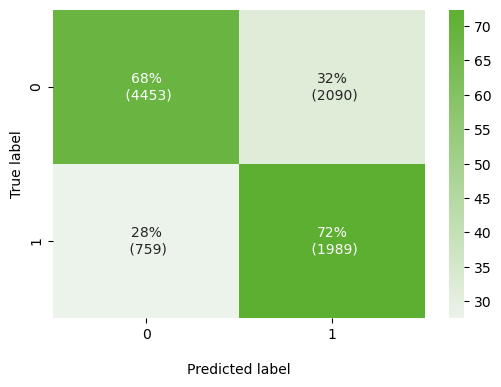

In [10]:
colors = {"G_depressionscore": "#0062BE", "G_anxietyscore": "#D18F00", "G_totalscore": "#5DAF31"}

l_cm = []

target = targets[2]

recall = []
precision = [] 

size = 2
cc = 1

n_batch = 1
n_cv = 5

for batch in range(n_batch):
    for cv in range(n_cv):
        
        # load data
        path_data = CONFIG.path_results+"results/" + target+"/"+CONFIG.clf_name+"/data_scaled_batch_"+str(batch+1)+"_cv_"+str(cv+1)+".csv"

        data = pd.read_csv(path_data, index_col=[0,1])
        data_test = data.loc['test']
        y_test = data_test[target]
        X_test = data_test.drop([target],axis=1)

        # load model
        model = joblib.load(CONFIG.path_results+"results/" + target+"/"+CONFIG.clf_name+"/model_"+str(batch+1)+ "_cv_"+str(cv+1)+".sav")
            
        # aggregated confusion matrix
        y_pred = model.predict(X_test)

        if size == 2:
            y_pred[np.where(y_pred==2)[0]] = 1
            y_test = y_test.replace(2,1)

            #y_pred[np.where(y_pred==1)[0]] = 0
            #y_pred[np.where(y_pred==2)[0]] = 1
            #y_test = y_test.replace(1,0)
            #y_test = y_test.replace(2,1)

        cm = confusion_matrix(y_test, y_pred)

        l_cm.append(cm)
        recall.append(cm[cc,cc]/np.sum(cm[cc,:]))
        precision.append(cm[cc,cc]/np.sum(cm[:,cc]))

cm_mean = np.zeros((size,size))
cm_std = np.zeros((size,size))
cm_sum= np.zeros((size,size))

for i in range(size):
    for j in range(size):
        aux = []
        aux2 = []
        for cm in l_cm:
            aux.append(cm[i,j]/np.sum(cm[i,:])*100)
            aux2.append(cm[i,j])

            
        cm_mean[i,j] = np.mean(aux)
        cm_sum[i,j] = np.sum(aux2)
        cm_std[i,j] = np.std(aux)        

#l_plot = cm_mean.tolist()
l_plot = cm_sum.tolist()
for i in range(size):
    for j in range(size):
        #l_plot[i][j] = str(np.round(cm_mean[i,j],2)) + "%" + " ("+ r'$\pm$ ' + str(np.round(cm_std[i,j],2)) + ")"
        l_plot[i][j] = str(int(np.round(cm_mean[i,j],0))) + "%" + "\n ("+ str(int(cm_sum[i,j])) + ")"


# plot
fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(cm_mean, annot=l_plot,fmt='', cmap=sns.light_palette(colors[target], as_cmap=True),ax = ax)

ax.set_xlabel('\nPredicted label')
ax.set_ylabel('True label');

## Ticket labels - List must be in alphabetical order
#ax.xaxis.set_ticklabels(['None','Mild','Severe'])
#ax.yaxis.set_ticklabels(['None','Mild','Severe'])

In [11]:
np.mean(recall)

0.7233874034832622

In [12]:
np.std(recall)

0.016421810655033717

In [13]:
np.mean(precision)

0.48727071882300377

In [14]:
np.std(precision)

0.021694177555610896

In [447]:
y_pred[np.where(y_pred==2)[0]] = 1

In [448]:
y_pred

array([0, 1, 1, ..., 1, 0, 0], dtype=int64)

In [449]:
cm = confusion_matrix(y_test.replace(2,1), y_pred)

In [451]:
from sklearn.metrics import ConfusionMatrixDisplay

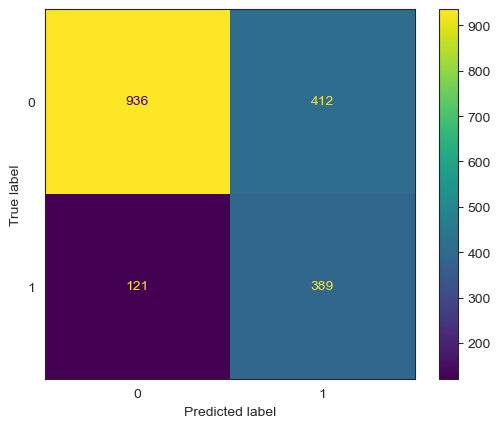

In [461]:
ConfusionMatrixDisplay.from_predictions(y_test.replace(2,1), y_pred)
plt.show()

## Confussion matrices

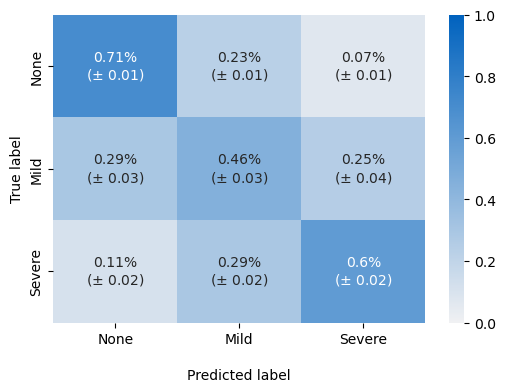

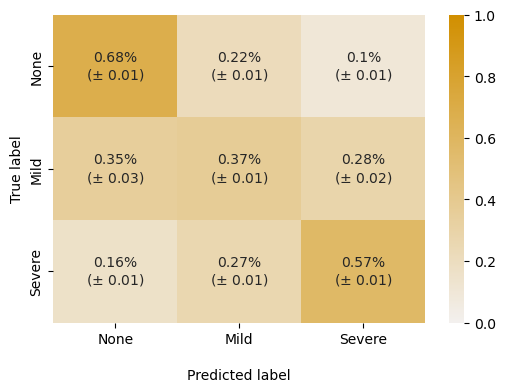

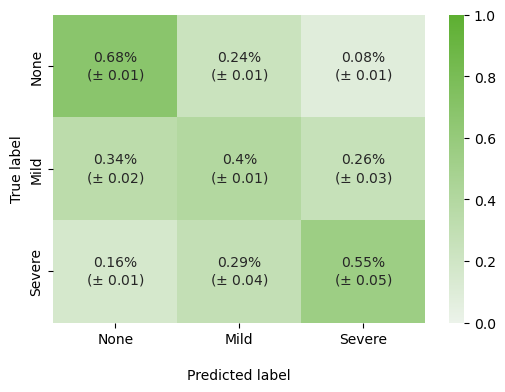

In [5]:
targets = ["G_depressionscore", "G_anxietyscore", "G_totalscore"]
n_batch = 1
n_cv = 5
    
for target in targets:
    utils.compute_confussion_matrix(target,n_batch,n_cv,CONFIG)

In [5]:
sns.set_style("whitegrid")

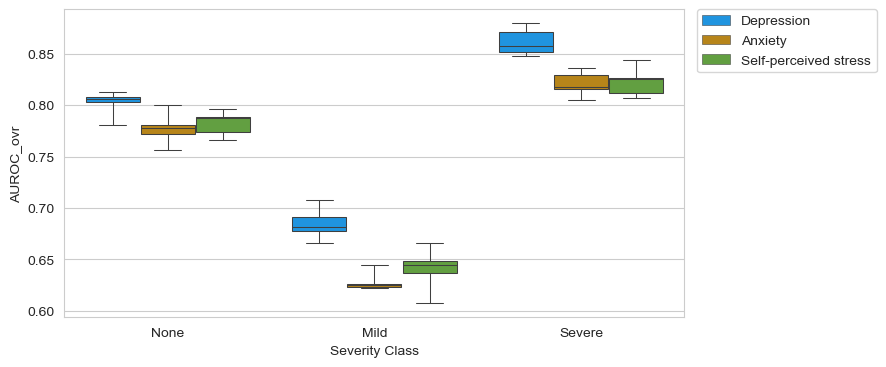

In [6]:
targets = ['G_depressionscore', 'G_anxietyscore','G_totalscore']
n_batch = 1
n_cv = 5

utils.compute_roc_auc_performance(targets,n_batch,n_cv,CONFIG)

In [58]:
l1 =[]
l2 =[]
l3 =[]

target = targets[2]

for batch in range(n_batch):
    for cv in range(n_cv):
    
        # load data
        path_data = CONFIG.path_results+"results/" + target+"/"+CONFIG.clf_name+"/data_scaled_batch_"+str(batch+1)+"_cv_"+str(cv+1)+".csv"
        data = pd.read_csv(path_data, index_col=[0,1])
        data_test = data.loc['test']
        y_test = data_test[target]
        X_test = data_test.drop([target],axis=1)

        # load model
        model = joblib.load(CONFIG.path_results+"results/" + target+"/"+CONFIG.clf_name+"/model_"+str(batch+1)+ "_cv_"+str(cv+1)+".sav")

        # aggregated confusion matrix
        y_prob = model.predict_proba(X_test)
        value = roc_auc_score(y_test, y_prob,multi_class="ovr", average=None)

        l1.append(value[0])
        l2.append(value[1])
        l3.append(value[2])

In [59]:
np.mean(l2)

0.6405322656869926

In [60]:
bootstrap((l2,), np.mean, confidence_level=0.95).confidence_interval

ConfidenceInterval(low=0.6204804488533351, high=0.6547476647302408)

### Explainability (Depression)

In [50]:
target = "G_depressionscore"
n_batch = 1
n_cv = 5

n_neighbors = 8#11
spread = 0.92
min_dist = 0.02

n_clu = 9

pred_local = 2

df_mapper, selected_features_dep, d_freq, d_shap_dep = utils.compute_shap_values(target,n_batch,n_cv,CONFIG)

df_mapper = utils.compute_UMAP(df_mapper,target,selected_features_dep,n_neighbors,spread,min_dist,40)
df_mapper =  utils.compute_clustering(df_mapper,target,n_clu)
df_profiles,df_plot,label_n = utils.compute_risk_profiles(df_mapper,target,selected_features_dep,raw = True)

In [51]:
df_global_d = df_mapper[df_mapper.columns[2:2+len(selected_features_dep)]]

In [6]:
clu_local = 1

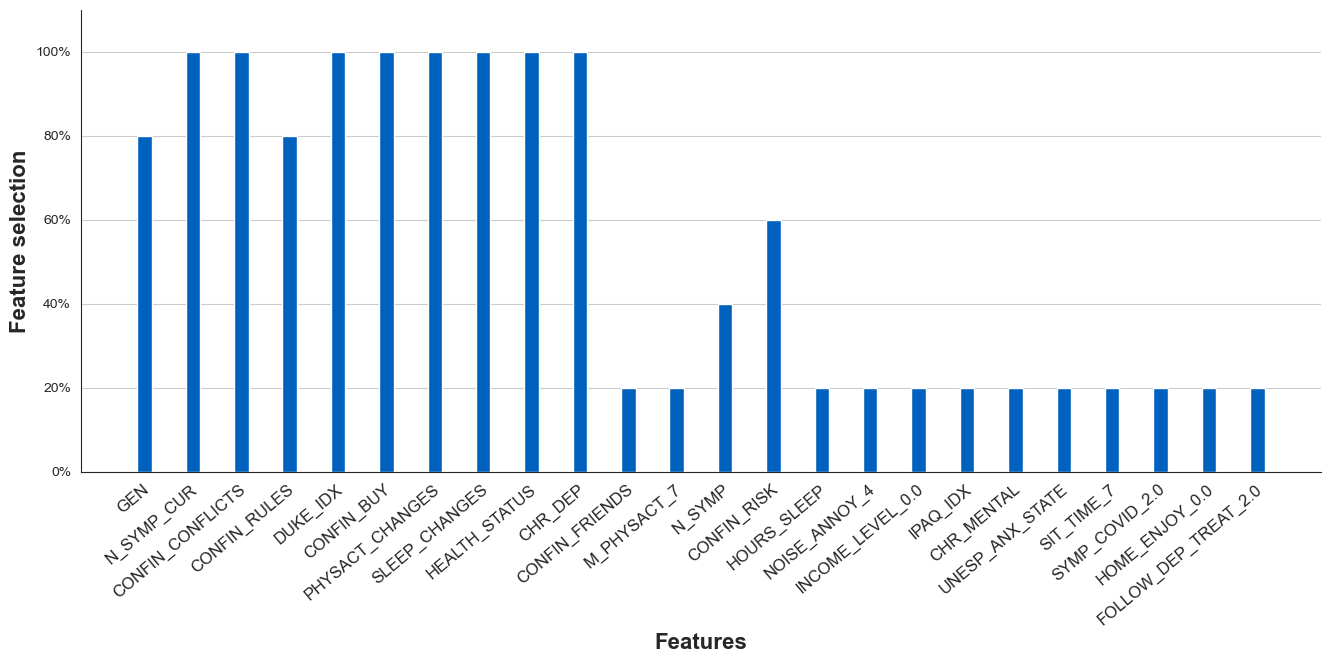

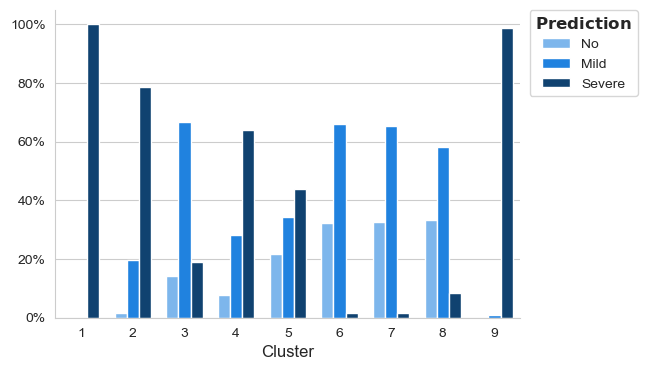

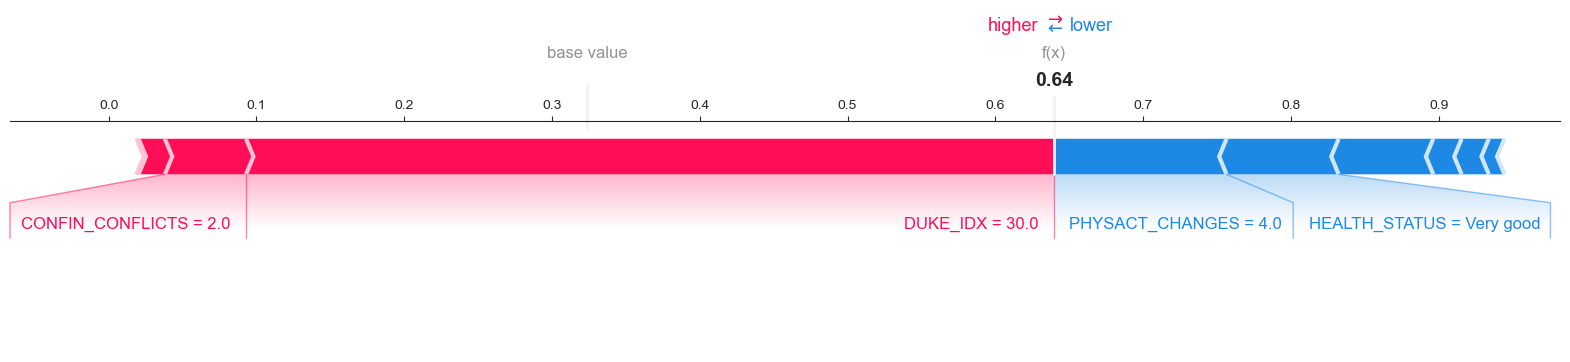

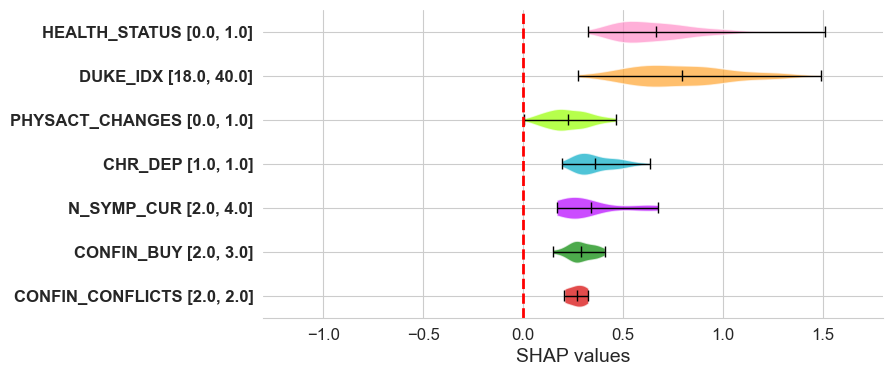

In [7]:
utils.compute_feature_selection_frequency(d_freq, target)
utils.compute_pred_per_cluster(df_mapper,target,n_clu)
pat = utils.compute_shap_local_exp(df_mapper,target,clu_local,pred_local,n_batch,n_cv,0.12,CONFIG,104)
risk_factors = utils.compute_risk_factors(df_mapper, target, df_profiles, df_plot, label_n,raw = True)

In [36]:
pat

104

In [11]:
for l in risk_factors:
    print(np.mean(l))

0.6644091
0.76553154
0.22565389
0.37448627
0.33827862
0.2882458
0.2665281


In [26]:
sns.set_style("whitegrid")

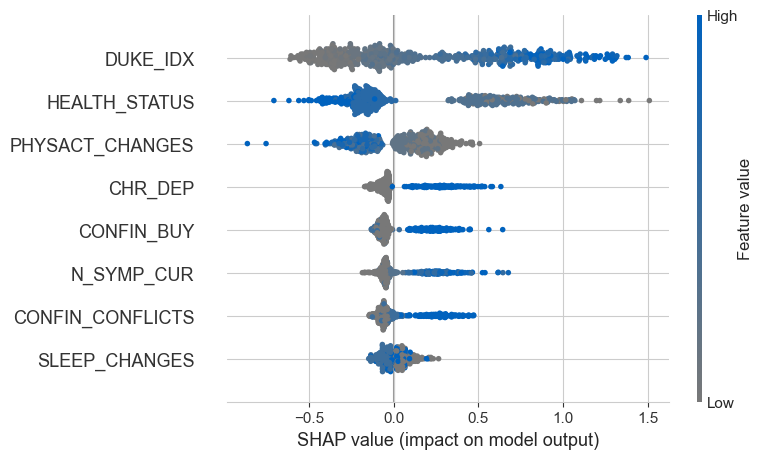

In [8]:
fig = plt.gcf()

colors = ["#787878", "#0062BE"]
cm = LinearSegmentedColormap.from_list("Custom", colors)
shap.summary_plot(df_mapper[df_mapper.columns[2:2+len(selected_features_dep)]].values,features=df_mapper[selected_features_dep],cmap=cm,feature_names=selected_features_dep)
fig.savefig("C:/Users/gvillanueva/Desktop/Projects/Mental_health_COVID19/reports/figures/beeswarm_dep.svg", format='svg', dpi=1200,bbox_inches="tight")

### Explainability (Anxiety)

In [52]:
target = "G_anxietyscore"
n_batch = 1
n_cv = 5

n_neighbors = 11 # 8
spread = 0.96 # 1
min_dist = 0.011 # 0.02

n_clu = 10# 11
clu_local = 7
pred_local = 2

ran = 40

df_mapper, selected_features_anx, d_freq, d_shap_anx = utils.compute_shap_values(target,n_batch,n_cv,CONFIG)
df_mapper = utils.compute_UMAP(df_mapper,target,selected_features_anx,n_neighbors,spread,min_dist,ran)
df_mapper =  utils.compute_clustering(df_mapper,target,n_clu)
df_profiles,df_plot,label_n =  utils.compute_risk_profiles(df_mapper,target,selected_features_anx,raw = True)

In [53]:
df_global_a = df_mapper[df_mapper.columns[2:2+len(selected_features_anx)]]

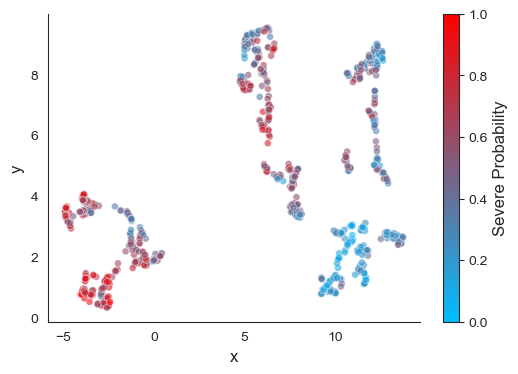

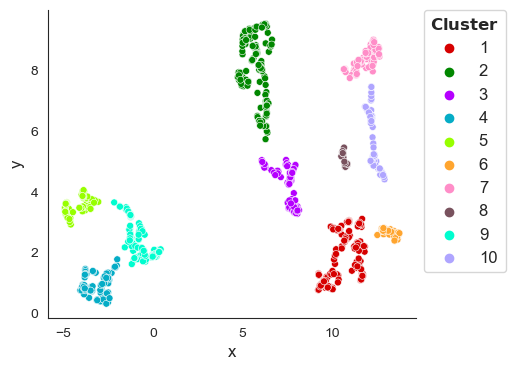

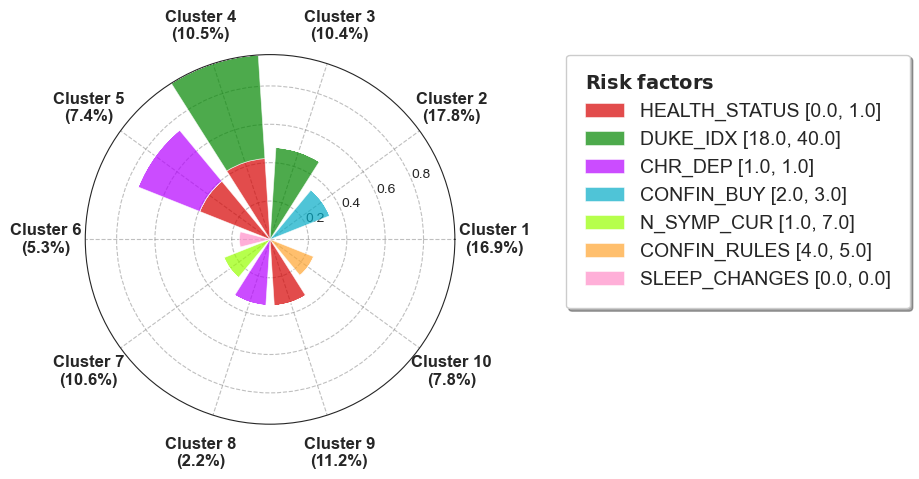

In [10]:
plt.show()

In [11]:
clu_local = 3

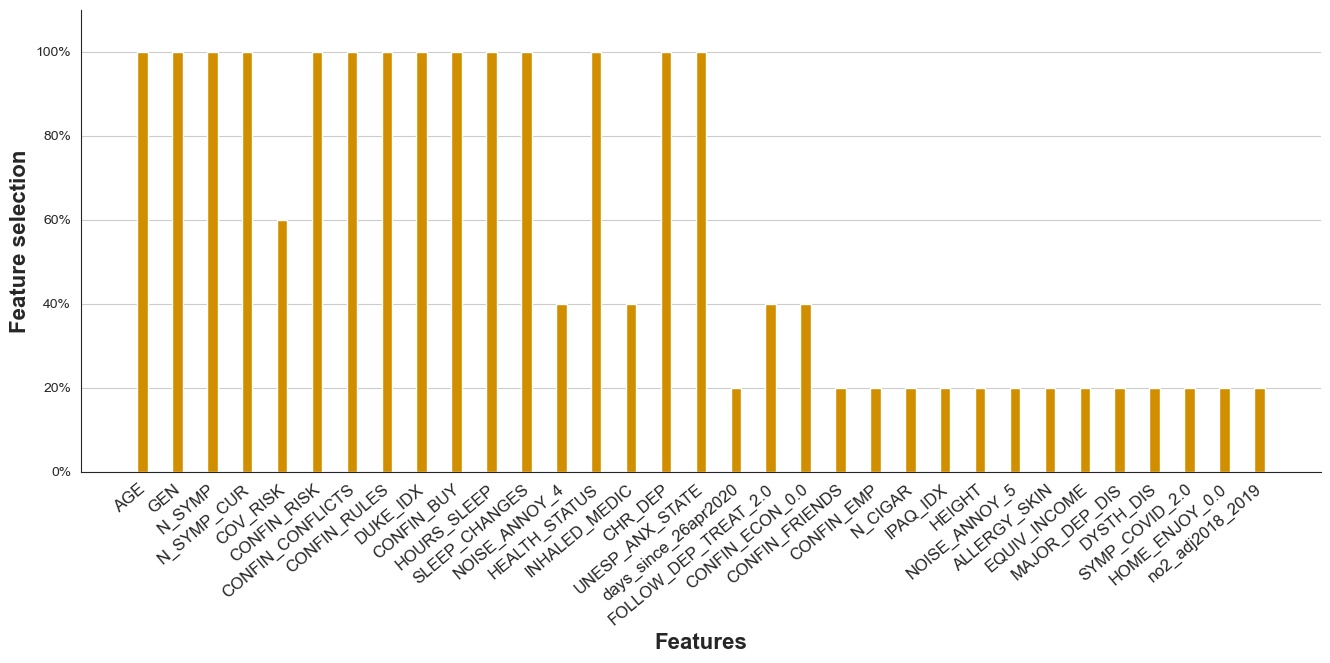

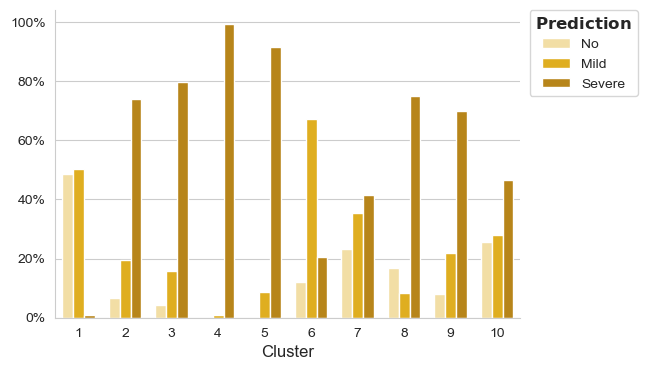

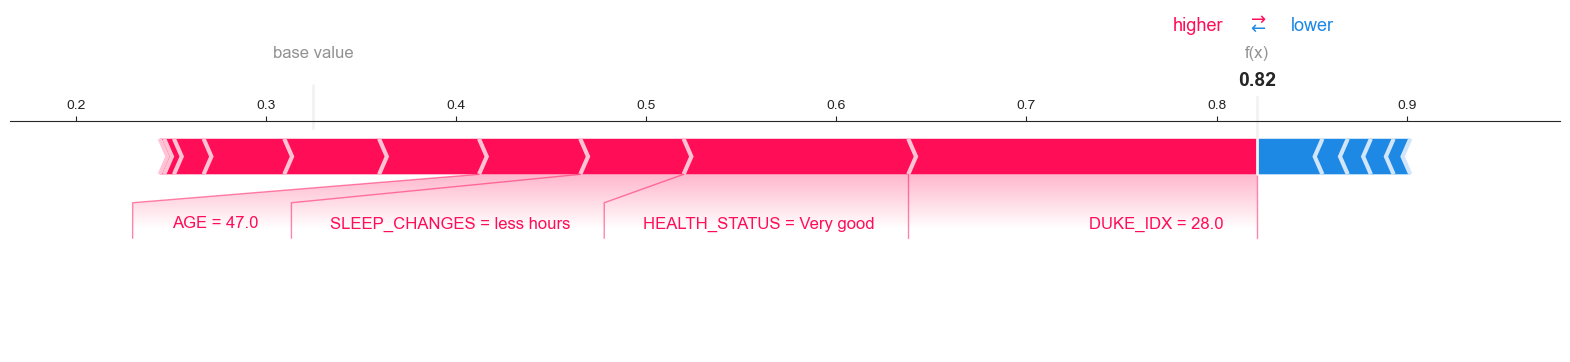

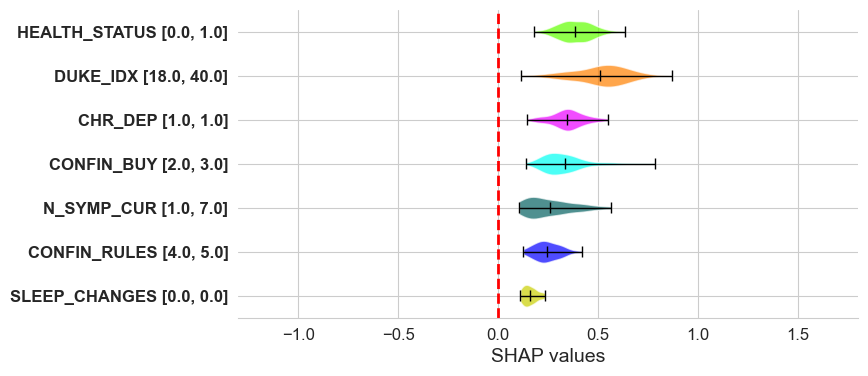

In [12]:
utils.compute_feature_selection_frequency(d_freq, target)
utils.compute_pred_per_cluster(df_mapper,target,n_clu)
pat = utils.compute_shap_local_exp(df_mapper,target,clu_local,pred_local,n_batch,n_cv,0.12,CONFIG,855)
risk_factors = utils.compute_risk_factors(df_mapper, target, df_profiles, df_plot, label_n,raw = False)

In [32]:
pat

855

In [14]:
risk_factors.reverse()

In [15]:
for l in risk_factors:
    print(np.mean(l))

0.3860466
0.511691
0.33955777
0.3369835
0.2587066
0.24504524
0.16075954


In [45]:
sns.set_style("whitegrid")

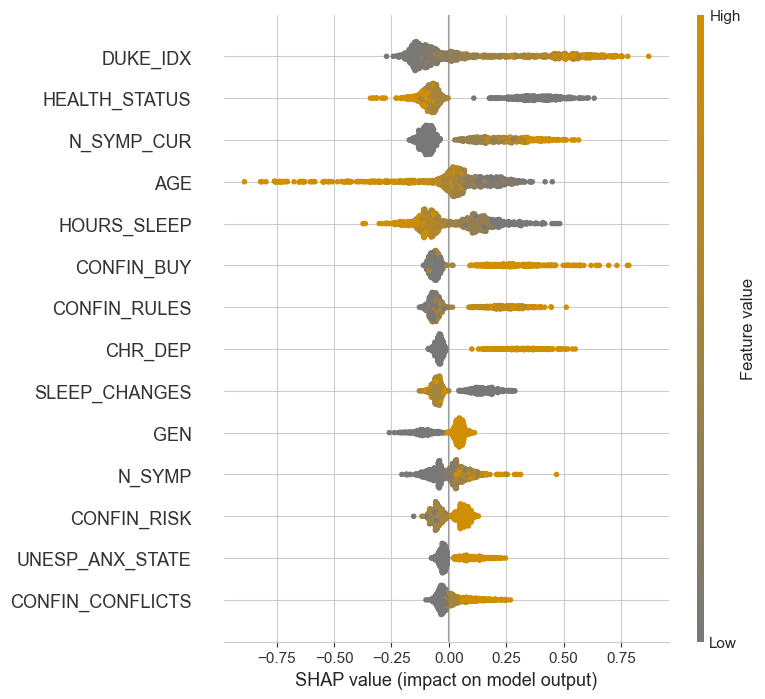

In [13]:
fig = plt.gcf()

colors = ["#787878", "#D18F00"] # first color is black, last is red
cm = LinearSegmentedColormap.from_list("Custom", colors)
shap.summary_plot(df_mapper[df_mapper.columns[2:2+len(selected_features_anx)]].values,features=df_mapper[selected_features_anx],cmap=cm,feature_names=selected_features_anx)
fig.savefig("C:/Users/gvillanueva/Desktop/Projects/Mental_health_COVID19/reports/figures/beeswarm_anx.svg", format='svg', dpi=1200,bbox_inches="tight")

### Explainability (Self-perceived stress)

In [32]:
target = "G_totalscore"
n_batch = 1
n_cv = 5

n_neighbors = 17 #33
spread = 0.98
min_dist = 0.02

n_clu = 10

clu_local = 0
pred_local = 2

df_mapper, selected_features_tot, d_freq, d_shap_tot = utils.compute_shap_values(target,n_batch,n_cv,CONFIG)
df_mapper = utils.compute_UMAP(df_mapper,target,selected_features_tot,n_neighbors,spread,min_dist,40)
df_mapper =  utils.compute_clustering(df_mapper,target,n_clu)
df_profiles,df_plot,label_n =  utils.compute_risk_profiles(df_mapper,target,selected_features_tot,raw = True)

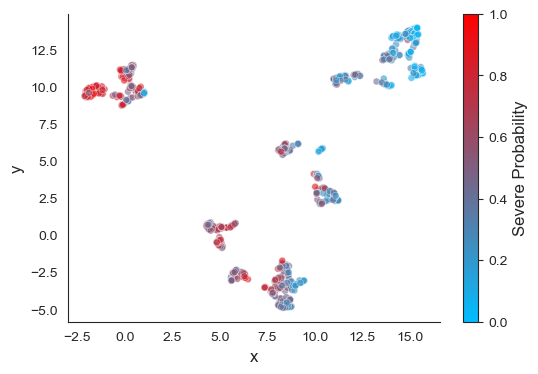

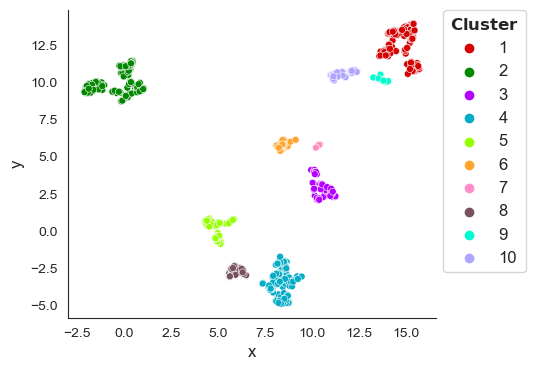

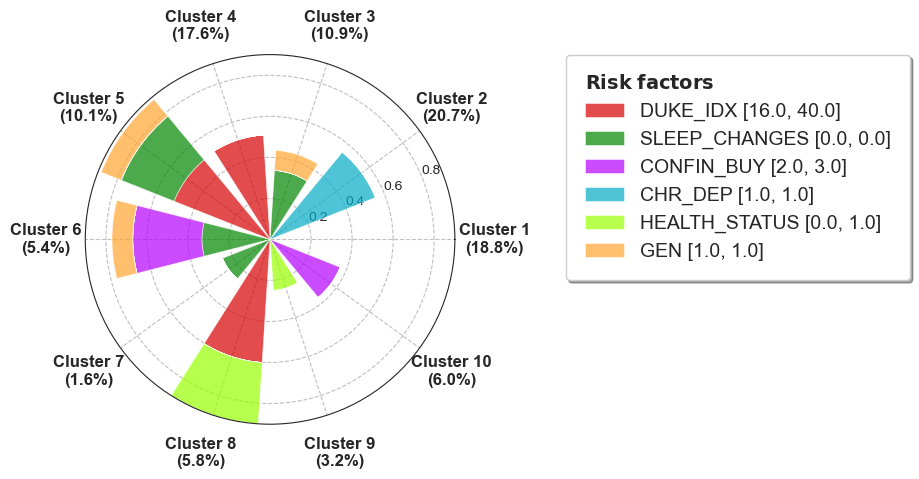

In [33]:
plt.show()

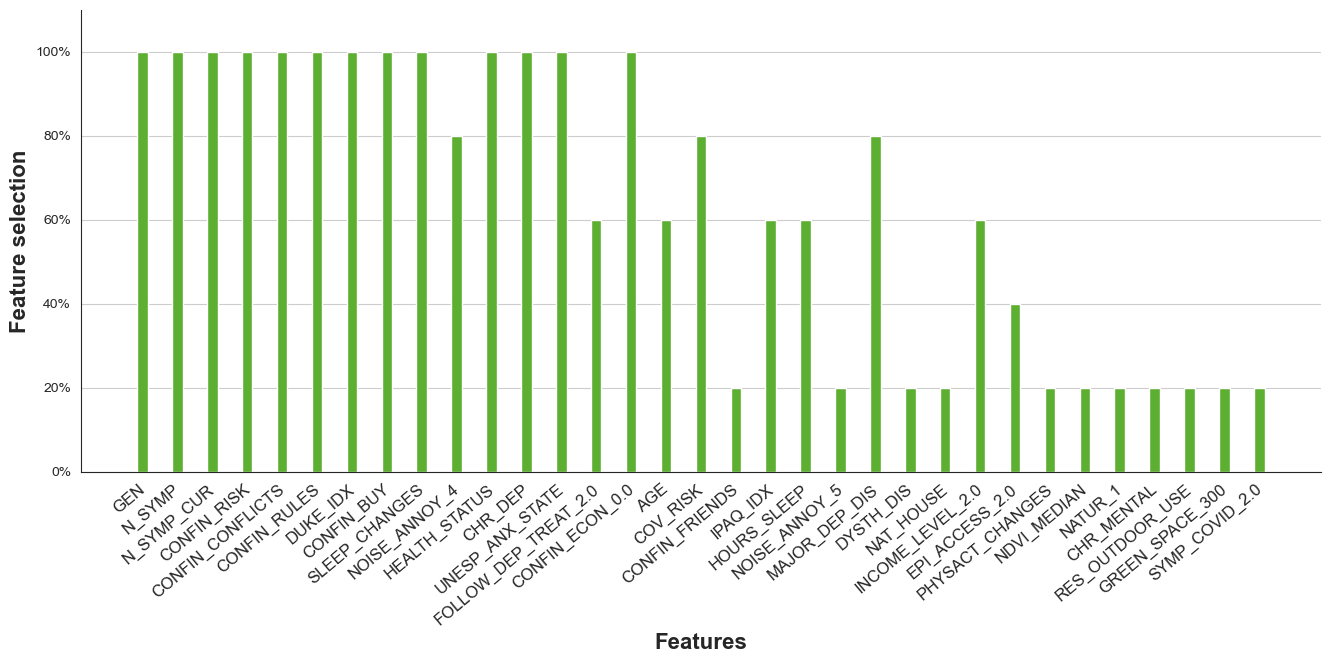

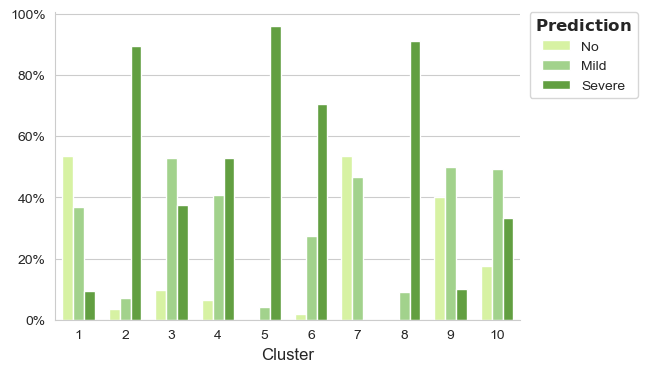

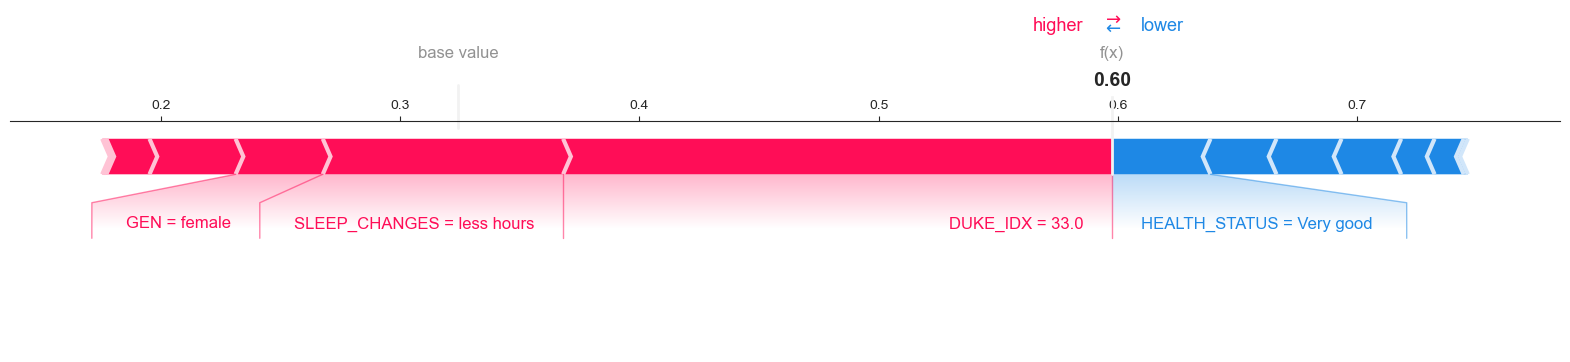

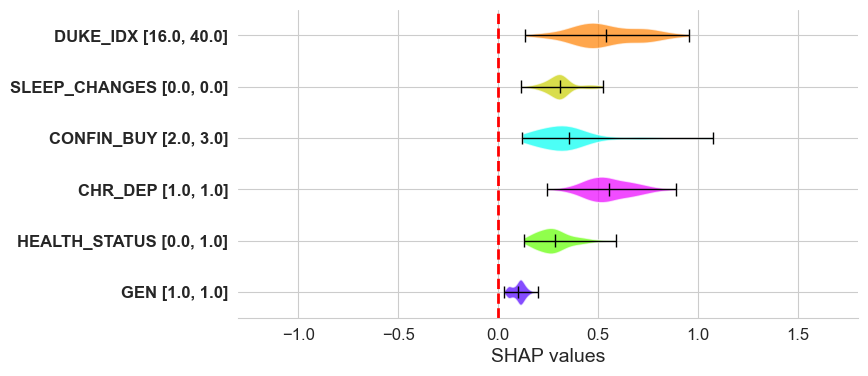

In [34]:
clu_local = 4
utils.compute_feature_selection_frequency(d_freq, target)
utils.compute_pred_per_cluster(df_mapper,target,n_clu)
pat = utils.compute_shap_local_exp(df_mapper,target,clu_local,pred_local,n_batch,n_cv,0.12,CONFIG,51)
risk_factors = utils.compute_risk_factors(df_mapper, target, df_profiles, df_plot, label_n,raw = False)

In [22]:
pat

51

In [18]:
risk_factors.reverse()

In [19]:
for l in risk_factors:
    print(np.mean(l))

0.5385608
0.31139943
0.3621316
0.5526364
0.28195143
0.10090246


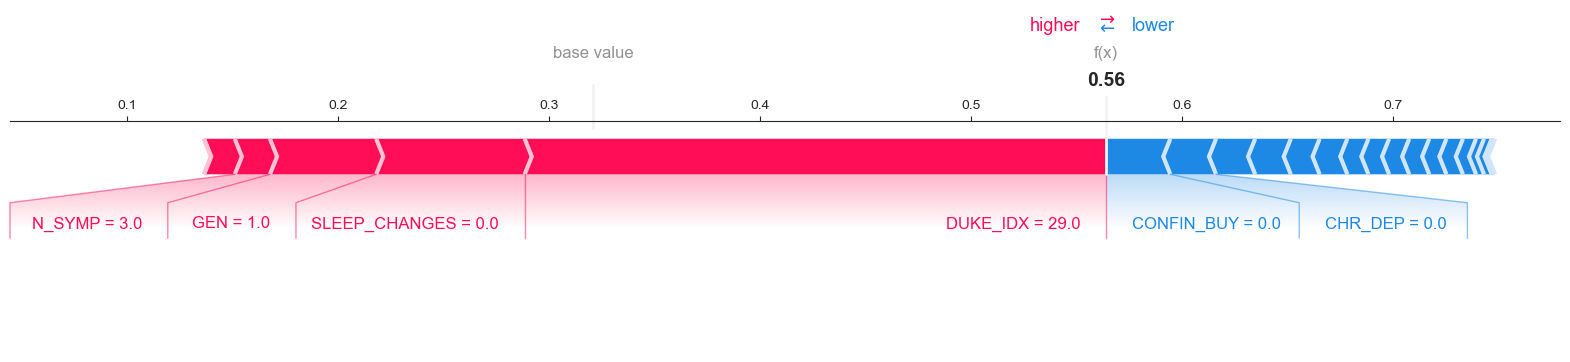

In [22]:
clu_local = 2
utils.compute_shap_local_exp(df_mapper,target,clu_local,pred_local,n_batch,n_cv,0.05,CONFIG)

In [50]:
sns.set_style("whitegrid")

In [43]:
df_global_s = df_mapper[df_mapper.columns[2:2+len(selected_features_tot)]]

In [63]:
df_dep = pd.DataFrame(np.abs(df_global_d.values).mean(0),index= selected_features_dep).transpose()

In [64]:
df_anx = pd.DataFrame(np.abs(df_global_a.values).mean(0),index= selected_features_anx).transpose()

In [65]:
df_tot = pd.DataFrame(np.abs(df_global_s.values).mean(0),index= selected_features_tot).transpose()

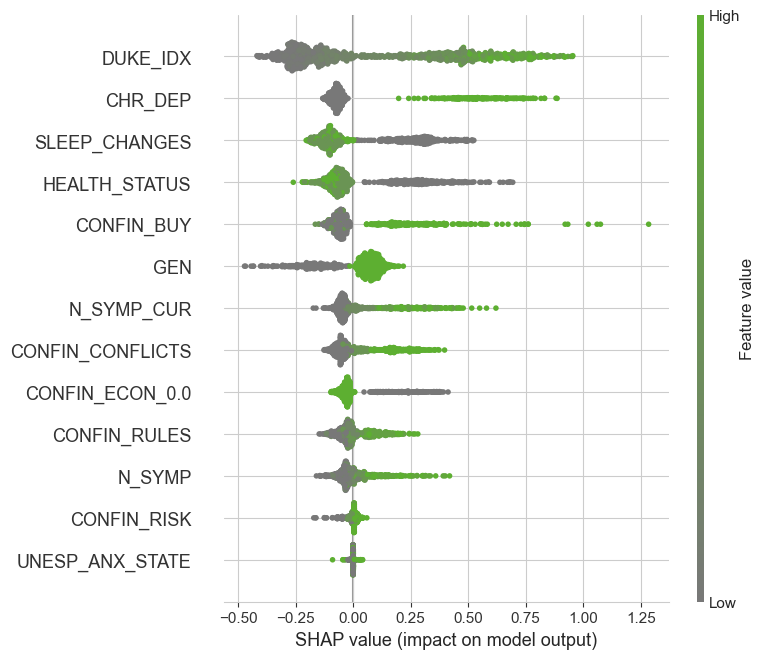

In [17]:
fig = plt.gcf()

colors = ["#787878", "#5DAF31"] # first color is black, last is red
cm = LinearSegmentedColormap.from_list("Custom", colors)
shap.summary_plot(df_mapper[df_mapper.columns[2:2+len(selected_features_tot)]].values,features=df_mapper[selected_features_tot],cmap=cm,feature_names=selected_features_tot)
fig.savefig("C:/Users/gvillanueva/Desktop/Projects/Mental_health_COVID19/reports/figures/beeswarm_tot.svg", format='svg', dpi=1200,bbox_inches="tight")

In [61]:
features_list = set().union(*[selected_features_tot,selected_features_anx,selected_features_dep])

In [83]:
df_dep

,N_SYMP_CUR,CONFIN_CONFLICTS,DUKE_IDX,CONFIN_BUY,PHYSACT_CHANGES,SLEEP_CHANGES,HEALTH_STATUS,CHR_DEP
0,0.111079,0.103887,0.455852,0.113327,0.189835,0.058857,0.407582,0.119592


In [85]:
df_dep["DUKE_IDX"][0]

0.4558519

In [19]:
l_dep2 = list(d_shap_dep.keys())
l_anx2 = list(d_shap_anx.keys())
l_tot2 = list(d_shap_tot.keys())

In [86]:
d_def_dep = {}
d_def_anx = {}
d_def_tot = {}

for var in features_list:
    if var in l_dep2:
        if var in list(df_dep.columns):
            d_def_dep[var] = df_dep[var][0]
        else:
            d_def_dep[var] = d_shap_dep[var]
    else:
        d_def_dep[var] = 0

    if var in l_anx2:
        if var in list(df_anx.columns):
            d_def_anx[var] = df_anx[var][0]
        else:
            d_def_anx[var] = d_shap_anx[var]
    else:
        d_def_anx[var] = 0

    if var in l_tot2:
        if var in list(df_tot.columns):
            d_def_tot[var] = df_tot[var][0]
        else:
            d_def_tot[var] = d_shap_tot[var]
    else:
        d_def_tot[var] = 0


In [87]:
d_def_dep

{'CONFIN_BUY': 0.11332664,
 'CONFIN_CONFLICTS': 0.10388728,
 'CONFIN_RISK': 0.04491415123144785,
 'CONFIN_ECON_0.0': 0,
 'CONFIN_RULES': 0.017535461112856865,
 'DUKE_IDX': 0.4558519,
 'PHYSACT_CHANGES': 0.18983474,
 'SLEEP_CHANGES': 0.058856964,
 'HOURS_SLEEP': 0.15682367980480194,
 'N_SYMP': 0.10185128450393677,
 'N_SYMP_CUR': 0.11107932,
 'HEALTH_STATUS': 0.40758198,
 'CHR_DEP': 0.11959212,
 'UNESP_ANX_STATE': 0.025825446471571922,
 'GEN': 0.09188029915094376,
 'AGE': 0}

In [88]:
features_list

['CONFIN_BUY',
 'CONFIN_CONFLICTS',
 'CONFIN_RISK',
 'CONFIN_ECON_0.0',
 'CONFIN_RULES',
 'DUKE_IDX',
 'PHYSACT_CHANGES',
 'SLEEP_CHANGES',
 'HOURS_SLEEP',
 'N_SYMP',
 'N_SYMP_CUR',
 'HEALTH_STATUS',
 'CHR_DEP',
 'UNESP_ANX_STATE',
 'GEN',
 'AGE']

In [89]:
features_list = [
 'CONFIN_BUY',
 'CONFIN_CONFLICTS',
 'CONFIN_RISK',
 'CONFIN_ECON_0.0',
 'CONFIN_RULES',
 'DUKE_IDX',

 'PHYSACT_CHANGES',
 'SLEEP_CHANGES',
 'HOURS_SLEEP',

 'N_SYMP',
 'N_SYMP_CUR',
 'HEALTH_STATUS',
 'CHR_DEP',
 'UNESP_ANX_STATE',

 'GEN',
 'AGE'
]

In [90]:
d_def_dep_sorted = {}
for var in features_list:
    d_def_dep_sorted[var] = d_def_dep[var]

d_def_anx_sorted = {}
for var in features_list:
    d_def_anx_sorted[var] = d_def_anx[var]

d_def_tot_sorted = {}
for var in features_list:
    d_def_tot_sorted[var] = d_def_tot[var]

In [91]:
sns.set_style("whitegrid")

In [98]:
fig, ax = plt.subplots(figsize=(16, 6))

barWidth = 0.2
br1 = range(len(features_list))
br1 = [1,2,3,4,5,6,8,9,10,12,13,14,15,16,18,19]
br2 = [x + barWidth for x in br1]
br3 = [x + 2*barWidth for x in br1]

ax.bar(br1, d_def_dep_sorted.values(), color ="#0062BE", width = barWidth, label = "Depression")
ax.bar(br2, d_def_anx_sorted.values(), color ="#D18F00", width = barWidth, label = "Anxiety")
ax.bar(br3, d_def_tot_sorted.values(), color ="#5DAF31", width = barWidth, label = "Self-perceived stress")

ax.set_xticks([r + 2*barWidth/3 for r in br1])
ax.set_xticklabels(features_list, rotation=40,ha='right',va='top', fontsize = 12)
ax.set_xlabel('Features', fontweight ='bold', fontsize = 16)
ax.set_ylim([0, .5])

ax.set_ylabel('mean(|SHAP|)', fontweight ='bold', fontsize = 16)
#ax.set_title('Risk factors importance', fontweight ='bold', fontsize = 25)
#ax.set_title('Protective factors importance', fontweight ='bold', fontsize = 25)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left",fontsize = 16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.plot([7.2,7.2],[0,0.5],'--k',linewidth = 2)
plt.text(3.8, 0.43, "Exposure \n to coronavirus", fontsize=16, color='black', horizontalalignment='center',verticalalignment='bottom')
plt.plot([11.2,11.2],[0,0.5],'--k',linewidth = 2)
plt.text(9.2, 0.43, "Lifestyle", fontsize=16, color='black', horizontalalignment='center',verticalalignment='bottom')
plt.text(14.3, 0.43, "Health", fontsize=16, color='black', horizontalalignment='center',verticalalignment='bottom')
plt.plot([17.2,17.2],[0,0.5],'--k',linewidth = 2)
plt.text(18.9, 0.43, "General", fontsize=16, color='black', horizontalalignment='center',verticalalignment='bottom')

Text(18.9, 0.43, 'General')

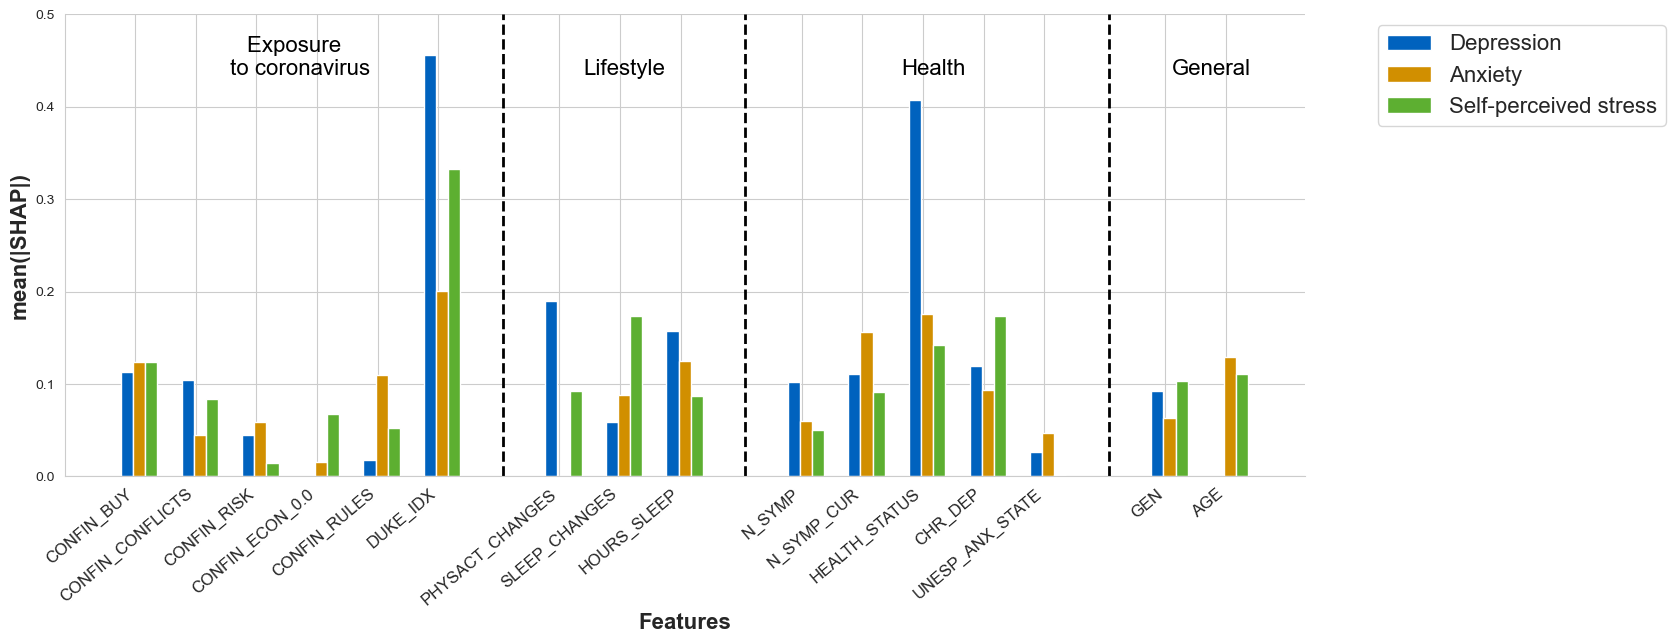

In [99]:
plt.show()

In [74]:
fig.savefig("C:/Users/gvillanueva/Desktop/Projects/Mental_health_COVID19/reports/figures/global_feature_importance.svg", format='svg', dpi=1200,bbox_inches="tight")

# Supportive figures

In [75]:
targets = ['G_depressionscore', 'G_anxietyscore','G_totalscore']

l1 = []
l2 = []
l3 = []


v_features = CONFIG.n_features

fig, ax = plt.subplots(figsize=(6, 5))
for target in targets:
    for batch in range(CONFIG.outer_cv):
        for cv in range(CONFIG.inner_cv):
            path_data = CONFIG.path_results+"results/"+target+"/"+CONFIG.clf_name+ "/scores"+str(batch+1)+ "_cv_"+str(cv+1)+".csv"
            data = pd.read_csv(path_data, index_col=[0])
            for i in range(len(v_features)):
                for cv_i in range(CONFIG.inner_cv):
                    #l1.append(cv_i)
                    l1.append(target)
                    l2.append(data.iloc[i,cv_i])
                    l3.append(v_features[i])

  
df_plot = pd.DataFrame([l1,l2,l3],index = ['cv','score','n_features']).transpose()
sns.set_style("whitegrid")
ax = sns.lineplot(x="n_features", y="score",hue = "cv", data=df_plot, errorbar=("sd")) 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
legend_handles, _= ax.get_legend_handles_labels()
ax.legend(legend_handles, ["Depression", "Anxiety", "Self-perceived stress"],fontsize = '12', bbox_to_anchor=(1.02,1),loc='upper left',borderaxespad=0,title = r'$\bf{Target}$',title_fontsize=12)
ax.set_xlabel('Number of features', fontsize=12)
ax.set_ylabel('Inner-cv score', fontsize=12)


#fig.savefig("C:/Users/gvillanueva/Desktop/Mental_Health/figures/features_performance.svg", format='svg', dpi=1200,bbox_inches="tight")

Text(0, 0.5, 'Inner-cv score')

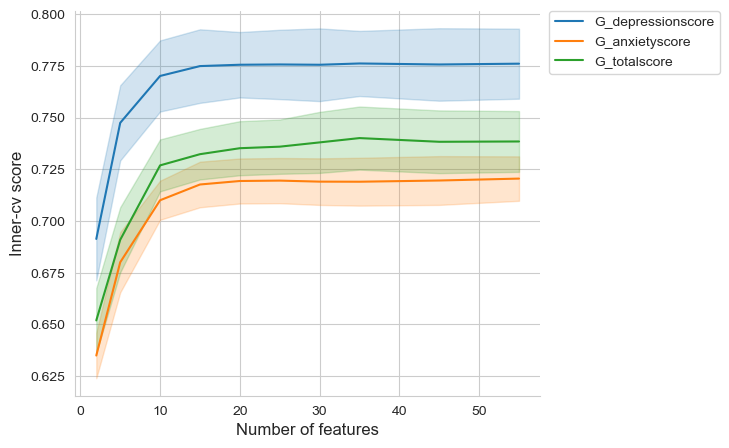

In [398]:
plt.show()

In [76]:
L = []

for cv in range(n_cv):
    l = []
    for target in targets:
        for batch in range(n_batch):
            
            path_data = CONFIG.path_results+"results/"+target+"/"+CONFIG.clf_name+ "/data_scaled_batch_"+str(batch+1)+"_cv_"+str(cv+1)+".csv"
            data = pd.read_csv(path_data, index_col=[0,1])
            l.append(len(data.columns)-1)
            
    L.append(l)


# Set data
df = pd.DataFrame({
'group': ['Depression','Anxiety','Self-perceived stress'],
'cv_1': L[0],
'cv_2': L[1],
'cv_3': L[2],
'cv_4': L[3],
'cv_5': L[4]
})

 
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
#plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
#plt.ylim(0,40)
 

# Ind1
values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Depression")
ax.fill(angles, values, "#0062BE", alpha=0.1)
 
# Ind2
values=df.loc[1].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Anxiety")
ax.fill(angles, values, "#D18F00", alpha=0.1)

values=df.loc[2].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Anxiety")
ax.fill(angles, values, "#5DAF31", alpha=0.1)

labels = ['cv_ ' + str(i+1) for i in range(5)]
ax.set_xticklabels(labels,fontweight ='bold',fontsize =12)

#ax.set_yticks([2,5,10,15,20,25,30,15])
ax.set_rlabel_position(0)
plt.yticks([2,10,20,30,40,50], [str(i) for i in [2,10,20,30,40,50]], color="grey", size=8)
plt.ylim(0,50)
#ax.grid(True)
# Add legend
legend_handles, _= ax.get_legend_handles_labels()
ax.legend(legend_handles, ["Depression", "Anxiety", "Self-perceived stress"],fontsize = '12', bbox_to_anchor=(1.02,1),loc='upper left',borderaxespad=0,title = r'$\bf{Target}$',title_fontsize=12)
#fig.savefig("C:/Users/gvillanueva/Desktop/Mental_Health/figures/n_features.svg", format='svg', dpi=1200,bbox_inches="tight")

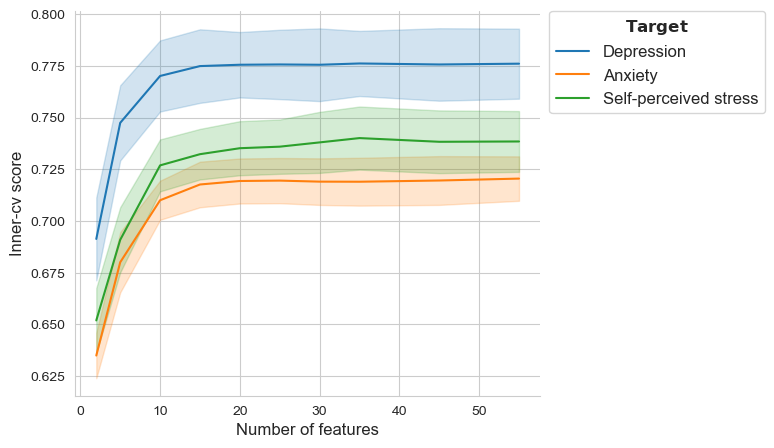

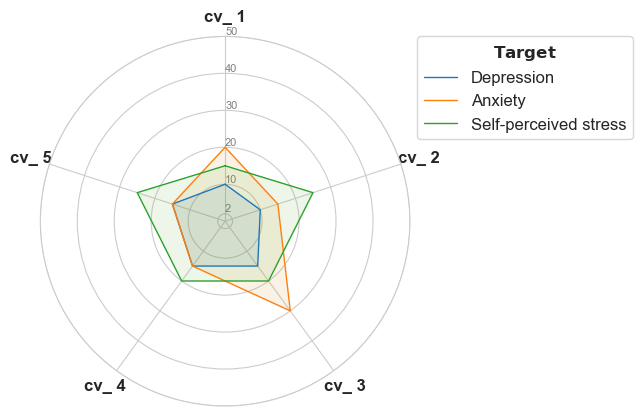

In [77]:
plt.show()

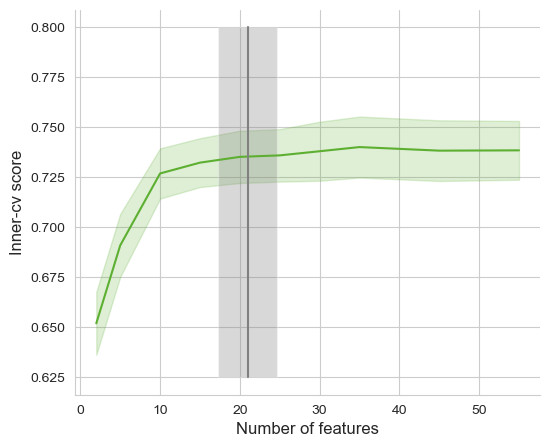

In [62]:
targets = ['G_depressionscore', 'G_anxietyscore','G_totalscore']

l1 = []
l2 = []
l3 = []


v_features = CONFIG.n_features
target = targets[2]

fig, ax = plt.subplots(figsize=(6, 5))
for batch in range(CONFIG.outer_cv):
    for cv in range(CONFIG.inner_cv):
        path_data = CONFIG.path_results+"results/"+target+"/"+CONFIG.clf_name+ "/scores"+str(batch+1)+ "_cv_"+str(cv+1)+".csv"
        data = pd.read_csv(path_data, index_col=[0])
        for i in range(len(v_features)):
            for cv_i in range(CONFIG.inner_cv):
                #l1.append(cv_i)
                l1.append(target)
                l2.append(data.iloc[i,cv_i])
                l3.append(v_features[i])

  
df_plot = pd.DataFrame([l1,l2,l3],index = ['cv','score','n_features']).transpose()
sns.set_style("whitegrid")
ax = sns.lineplot(x="n_features", y="score",hue = "cv", data=df_plot, errorbar=("sd"),palette=["#5DAF31"]) 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax.set_xlabel('Number of features', fontsize=12)
ax.set_ylabel('Inner-cv score', fontsize=12)
ax.plot([21,21],[0.625,0.8],'-',color = "gray",label = "Mean number of selected features")
ax.fill_between([21-3.7,21+3.7], [0.625,0.625],[0.8,0.8],facecolor = "grey",edgecolor = None,alpha = 0.3)
#legend_handles, _= ax.get_legend_handles_labels()
ax.get_legend().remove()
#ax.legend(legend_handles, ["Depression", "Anxiety", "Self-perceived stress"],fontsize = '12', bbox_to_anchor=(1.02,1),loc='upper left',borderaxespad=0,title = r'$\bf{Target}$',title_fontsize=12)


In [63]:
#fig.savefig("C:/Users/gvillanueva/Desktop/Mental_Health/figures/s_features_tot.svg", format='svg', dpi=1200,bbox_inches="tight")

In [9]:
np.array(L).mean(axis = 0)

array([13., 19., 21.])

In [64]:
L

[[10, 20, 15], [10, 15, 25], [15, 30, 20], [15, 15, 20], [15, 15, 25]]

In [17]:
np.array(L).std(axis = 0)

array([2.44948974, 5.83095189, 3.74165739])

### Hyperparameters

In [78]:
for target in targets:
    l = []
    for batch in range(CONFIG.outer_cv):
        for cv in range(CONFIG.inner_cv):
            model = joblib.load(CONFIG.path_results+"results/"+target+"/"+CONFIG.clf_name+ "/model_"+str(batch+1)+"_cv_"+str(cv+1)+".sav")
            params = model.get_params()
            if CONFIG.clf_name == "XGBoost":
                keys = ["n_estimators","learning_rate",'max_depth','reg_lambda','min_split_loss']
            l_hp = [params.get(key) for key in keys]
            l.append(l_hp)

    df_hp = pd.DataFrame(l, index = [i for i in range(CONFIG.inner_cv)], columns = keys)
    #print(np.mean(df_hp.values,axis = 0))
    #print(np.std(df_hp.values,axis = 0))
    print(df_hp)

   n_estimators  learning_rate  max_depth  reg_lambda min_split_loss
0            15          0.380          3         5.0           None
1            15          0.565          3         7.5           None
2            25          0.380          3         5.0           None
3            35          0.195          3         7.5           None
4            35          0.195          3        10.0           None
   n_estimators  learning_rate  max_depth  reg_lambda min_split_loss
0            45          0.195          3         5.0           None
1            45          0.195          3         2.5           None
2            45          0.195          3         7.5           None
3            35          0.195          3         2.5           None
4            45          0.195          3         7.5           None
   n_estimators  learning_rate  max_depth  reg_lambda min_split_loss
0            25          0.380          3        10.0           None
1            45          0.380    

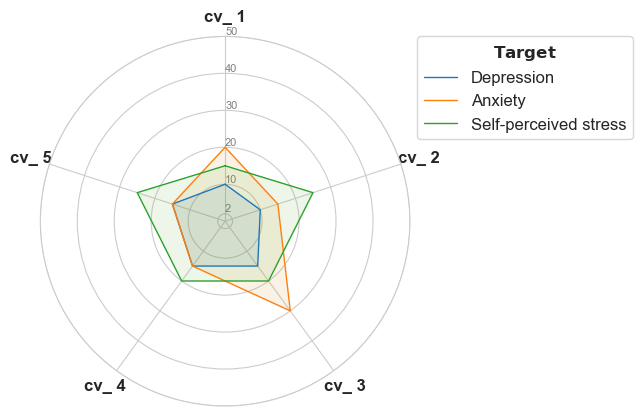

In [403]:
plt.show()